In [153]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from itertools import combinations
from itertools import product
from sklearn.metrics import r2_score 
from scipy.optimize import lsq_linear
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV 
from sklearn.cluster import KMeans
from scipy import linalg
from scipy.optimize import lsq_linear
from scipy.spatial.distance import cdist, pdist

In [168]:
#Section 1
#loading data including 20 scores, the indices of labeled genes among all genes , and their labeles.
all_gene_scores= pd.read_csv("case-study-all-genes.csv")
new_score= np.array(all_gene_scores.iloc[:,1:].T) 
labeled_gene_ind= np.load("labeled_gene_index.npy")# position of labeled genes in all_gene_scores 
labels=np.load("ASD_labels.npy")      # labels of genes (1 if ASD_related and 0 otherwise)

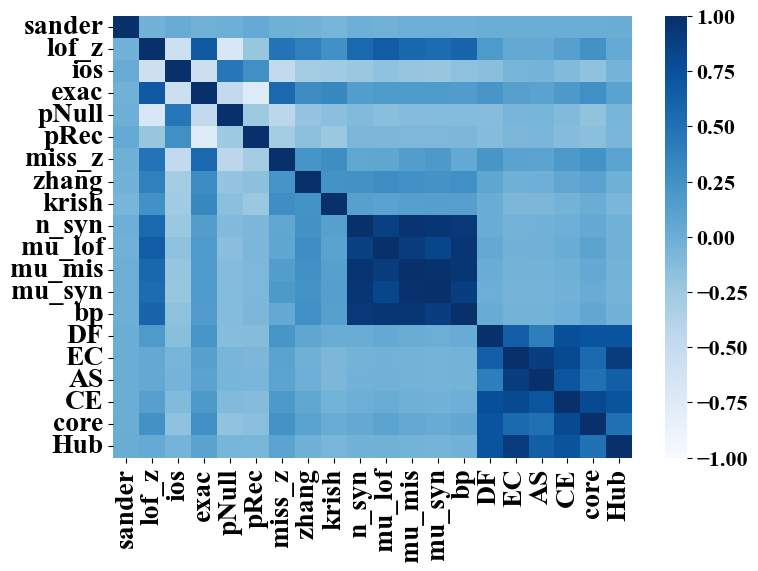

In [169]:
#Section 2
################################## plot covariance matrix
new_label=all_gene_scores.columns[1:]
fig, ax = plt.subplots(figsize=(8,6))
font = {'family' : 'Times New Roman',
        'size'   : 16}

plt.rc('font', **font)
plt.rc('lines', linewidth=2.5)
plt.rcParams['axes.linewidth'] = 2.5#set the value globally
plt.rc('hatch', color='k', linewidth=2.5)
cov=np.cov(new_score)   
sb.heatmap(cov,cmap="Blues",xticklabels=new_label, yticklabels=new_label,vmin=-1,vmax=1) 
plt.tight_layout() 
plt.show()

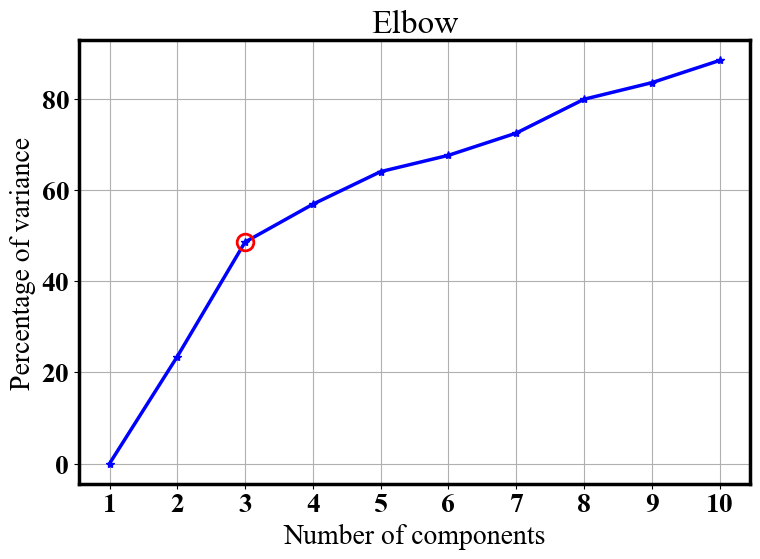

In [172]:
#Section 3:
#convert scores that have negative correlaion with other scores by multiplying them to -1
new_score[0]=-new_score[0]
new_score[2]=-new_score[2]
new_score[4]=-new_score[4]
new_score[5]=-new_score[5]

########################### Elbow method
K = range(1, 11)
KM = [KMeans(n_clusters=k, random_state=100).fit(new_score) for k in K] # kmeans clustering
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(new_score, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D, axis=1) for D in D_k]
dist = [np.min(D, axis=1) for D in D_k]
avgWithinSS = [sum(d) / new_score.shape[0] for d in dist]

# Total within-cluster sum of squares
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(new_score)**2) / new_score.shape[0]
bss = tss - wcss

kIdx = 2

# Elbow curve
fig, ax = plt.subplots(figsize=(8, 6))
font = {'family': 'Times New Roman', 'size': 20}

plt.rc('font', **font)
plt.rc('lines', linewidth=2.5)
plt.rcParams['axes.linewidth'] = 2.5
plt.rc('hatch', color='k', linewidth=2.5)

ax.plot(K, np.array(bss) / tss * 100, 'b*-')
ax.plot(K[kIdx], (np.array(bss) / tss * 100)[kIdx], marker='o', markersize=12,
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of components')
plt.ylabel('Percentage of variance')
plt.xticks(np.arange(1, 11))
plt.title('Elbow')
plt.tight_layout()


[0 0 0 0 0 0 0 0 0 2 2 2 2 2 1 1 1 1 1 1]


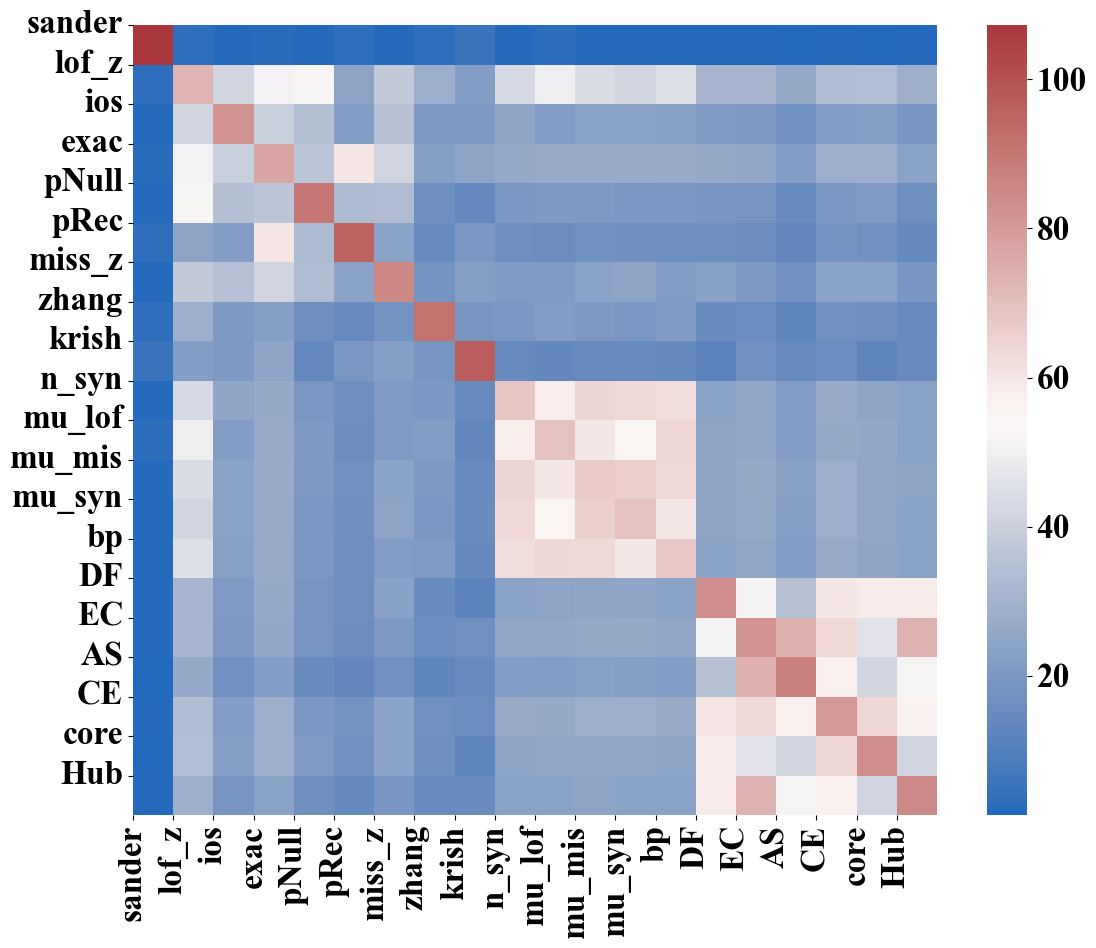

In [157]:
#Section 4:
################################# Quartet-based similarity matrix
cov=np.cov(new_score)
s=np.zeros([20,20])
for i in range (0,20):
    for j in range (0,20):
        for k in range(0,20):
           for l in range(0,20): 
            if k!=i and k!=j and l!=i and l!=j:
              b=np.abs((cov[i][j]*cov[k][l])-(cov[i][l]*cov[k][j]))
              s[i][j]=s[i][j]+b
              
clustering=AgglomerativeClustering(n_clusters=3).fit(s)
print(clustering.labels_)  
fig, ax = plt.subplots(figsize=(12,10))
font = {'family' : 'Times New Roman',
        'size'   : 24}

plt.rc('font', **font)
plt.rc('lines', linewidth=2.5)
plt.rcParams['axes.linewidth'] = 2.5#set the value globally
plt.rc('hatch', color='k', linewidth=2.5)
sb.heatmap(s,cmap="vlag")
plt.yticks(range(len(new_label)),new_label,rotation=0,fontsize=24, weight='bold')
plt.xticks(range(len(new_label)),new_label, rotation=90,fontsize=24, weight='bold')
plt.tight_layout()
#plt.savefig("S_real_data.tiff",dpi=300,format="tiff")   


In [158]:
#Section 5
# SUEL-CQO
##############################################
cov=np.cov(new_score)
c=[[0,1,2,3,4,5,6,7,8],[9,10,11,12,13],[14,15,16,17,18,19]] # index of scores categorized to be in the same list for the ones that are in the same block in quartet-based similarity matrix. 

############## creating systme of equations
A=np.zeros([190,27]) # dimension is m(m-1)/2* m+2kk+1, where m is number of scores and kk is number of latent models.
B=np.zeros([190,27])
z=np.zeros(190)
########### diagonal blocks equations
hh=[i for i in range(0,27)] # m+2kk+1
m=20 #number of scores
kk=3 #number of latent models
n=0
for k in range (0,3): #35 equations
  a = list(combinations(c[k], 2))
  for i in range (0,len(a)):
      A[n][a[i][0]]=1
      A[n][a[i][1]]=1
      A[n][m+k]=1
      z[n]=np.log(np.abs(cov[a[i][0]][a[i][1]]))
      B[n][a[i][0]]=hh[a[i][0]]
      B[n][a[i][1]]=hh[a[i][1]]
      B[n][m+k]=hh[m+k]
      n=n+1
      
for i in range(0,3):
    for j in range(i,3):
        if j != i:
          l1, l2 = c[i],c[j]
          a = list(product(l1, l2))
          for h in range (0,len(a)):
            A[n][a[h][0]]=1
            A[n][a[h][1]]=1
            A[n][m+kk+i]=1
            A[n][m+kk+j]=1
            A[n][m+2*kk]=1
            z[n]=np.log(np.abs(cov[a[h][0]][a[h][1]]))
            B[n][a[h][0]]=hh[a[h][0]]
            B[n][a[h][1]]=hh[a[h][1]]
            B[n][m+kk+i]=hh[m+kk+i]
            B[n][m+kk+j]=hh[m+kk+j]
            B[n][m+2*kk]=hh[m+2*kk]
            n=n+1               
    

aaa=[]
for i in range(0,len(A)):
    aaa.append(sum(A[i]))
    
#####################################
from scipy.optimize import lsq_linear
lb=np.array([[- np.inf,0] for i in range(0,22)]+[[-np.inf,-0.69]])
res=lsq_linear(A,z,bounds=(-np.inf,0))

################### computing accuracy of each predictor after estimating parameters by solving syetem of equations

#std1=np.exp(res.x[-1])-(((np.exp(res.x[0])**2))*(1-np.exp(res.x[-1]))*(np.exp(res.x[24])**2))
std2=np.exp(res.x[-1])-(((np.exp(res.x[0:9])**2))*(1-np.exp(res.x[-1]))*(np.exp(res.x[23])**2))
std3=np.exp(res.x[-1])-(((np.exp(res.x[9:14])**2))*(1-np.exp(res.x[-1]))*(np.exp(res.x[24])**2))
std4=np.exp(res.x[-1])-(((np.exp(res.x[14:20])**2))*(1-np.exp(res.x[-1]))*(np.exp(res.x[25])**2))
#acc1=(np.exp(res.x[0])*np.exp(res.x[24]))/std1
acc2=(np.exp(res.x[0:9])*np.exp(res.x[23]))/std2 
acc3=(np.exp(res.x[9:14])*np.exp(res.x[24]))/std3 
acc4=(np.exp(res.x[14:20])*np.exp(res.x[25]))/std4

new_score=np.load("paper3_score_2.npy")
new_score[0]=-new_score[0]
new_score[2]=-new_score[2]
new_score[4]=-new_score[4]
new_score[5]=-new_score[5]

acc=list(acc2)+list(acc3)+list(acc4)
acc=np.array(acc)

ensemble=[]
for i in range(0,20):
    a=new_score[i].T*np.exp(acc[i])
    ensemble.append(a)
ensemble=np.array(ensemble)
suel_cqo=np.sum(ensemble,axis=0)

fpr1, tpr1, threshold1=metrics.roc_curve(labels,suel_cqo[labeled_gene_ind],pos_label=1)
print("ROC-AUC:",auc(fpr1,tpr1))
fpr2,tpr2,threshold2=metrics.precision_recall_curve(labels,suel_cqo[labeled_gene_ind],pos_label=1)
print("PRC-AUC:",auc(tpr2,fpr2))


ROC-AUC: 0.843208029725426
PRC-AUC: 0.4128511407460527


In [159]:
# Section 6
############################# prediction accuracy of individual classifiers and selecting best_score
new_score=np.array(all_gene_scores.iloc[:,1:].T) 
new_score[0]=-new_score[0]
new_score[2]=-new_score[2]
new_score[4]=-new_score[4]
new_score[5]=-new_score[5]

roc=[]
prc=[]
for i in range (0,len(new_score)):
     fpr1, tpr1, threshold1=metrics.roc_curve(labels,new_score[i][labeled_gene_ind],pos_label=1)
     roc.append(auc(fpr1,tpr1))
     fpr2,tpr2,threshold2=metrics.precision_recall_curve(labels,new_score[i][labeled_gene_ind],pos_label=1)
     prc.append(auc(tpr2,fpr2))    
    
best_score=new_score[np.argmax(np.array(roc))]
fpr1, tpr1, threshold1=metrics.roc_curve(labels,best_score[labeled_gene_ind],pos_label=1)
print("ROC-AUC:",auc(fpr1,tpr1))
fpr2,tpr2,threshold2=metrics.precision_recall_curve(labels,best_score[labeled_gene_ind],pos_label=1)
print("PRC-AUC:",auc(tpr2,fpr2))

ROC-AUC: 0.7848091492544517
PRC-AUC: 0.48857973571380586


In [160]:
#Section 7
################ Eigen
new_score=np.array(all_gene_scores.iloc[:,1:].T) 
new_score[0]=-new_score[0]
new_score[2]=-new_score[2]
new_score[4]=-new_score[4]
new_score[5]=-new_score[5]
cov=np.cov(new_score)
s=np.zeros([20,20])
for i in range (0,20):
    for j in range (0,20):
        for k in range(0,20):
           for l in range(0,20): 
            if k!=i and k!=j and l!=i and l!=j:
              b=np.abs((cov[i][j]*cov[k][l])-(cov[i][l]*cov[k][j]))
              s[i][j]=s[i][j]+b
              
clustering=AgglomerativeClustering(n_clusters=19).fit(s)



c=[[0,1,2,3,4,5,6,7,8],[9,10,11,12,13],[14,15,16,17,18,19]]
A=np.zeros([500,20]) #m(m-1)/2, m+2k+1
B=np.zeros([500,20])
z=np.zeros(500)
n=0
hh=[i for i in range(0,20)]#res.x
for i in range(0,len(c)):
    for j in range(i,len(c)):
        if j != i:
          l1, l2 = c[i],c[j]
          a = list(product(l1, l2))
          for h in range (0,len(a)):
            A[n][a[h][0]]=1
            A[n][a[h][1]]=1
            z[n]=np.log(np.abs(cov[a[h][0]][a[h][1]]))
            B[n][a[h][0]]=hh[a[h][0]]
            B[n][a[h][1]]=hh[a[h][1]]
            n=n+1  
            
          
from scipy.optimize import lsq_linear
shi=lsq_linear(A,z)            


ensi=[]
for i in range(0,20):
    a=new_score[i].T*np.exp(shi.x[i])
    ensi.append(a)
ensi=np.array(ensi)
eigen=np.sum(ensi,axis=0)

fpr1, tpr1, threshold1=metrics.roc_curve(labels,eigen[labeled_gene_ind],pos_label=1)
print(auc(fpr1,tpr1))
fpr2,tpr2,threshold2=metrics.precision_recall_curve(labels,eigen[labeled_gene_ind],pos_label=1)
print(auc(tpr2,fpr2))
 


0.8224967427496019
0.4131275329099235


In [161]:
#Section 8
############################# average of individual predictors
new_score=np.array(all_gene_scores.iloc[:,1:].T) 
average=np.mean(new_score,axis=0)
fpr1, tpr1, threshold1=metrics.roc_curve(labels,average[labeled_gene_ind],pos_label=1)
print("ROC-AUC:",auc(fpr1,tpr1))
fpr2,tpr2,threshold2=metrics.precision_recall_curve(labels,average[labeled_gene_ind],pos_label=1)
print("PRC-AUC:",auc(tpr2,fpr2)) 


ROC-AUC: 0.6597886406408338
PRC-AUC: 0.20989406925895426


In [162]:
#Section 9
############################################################### SUEL.MF
# Set a fixed random seed for reproducibility
np.random.seed(2000)
new_score=np.array(all_gene_scores.iloc[:,1:].T) 
new_score[0]=-new_score[0]
new_score[2]=-new_score[2]
new_score[4]=-new_score[4]
new_score[5]=-new_score[5]
cov=np.cov(new_score)

s=np.zeros([20,20])
for i in range (0,20):
    for j in range (0,20):
        for k in range(0,20):
           for l in range(0,20): 
            if k!=i and k!=j and l!=i and l!=j:
              b=np.abs((cov[i][j]*cov[k][l])-(cov[i][l]*cov[k][j]))
              s[i][j]=s[i][j]+b
              
clustering=AgglomerativeClustering(n_clusters=4).fit(s)


cc=[[0,1,2,3,4,5,6,7,8],[9,10,11,12,13],[14,15,16,17,18,19]]
cv=np.concatenate(cc)
nn=[]
for i in range(0,len(cv)):
    nn.append(new_score[cv[i]])
new_score=nn    
R=np.cov(new_score)


################# computing B
B=np.zeros((20,len(cc)))
bb=np.random.rand(20,len(cc))
B=B+bb
for i in range(0,len(cc)):
    for j in range(0,20):
      if j not in cc[i]:
        B[j][i]=0

U=np.identity((len(cc)))
uu=np.random.rand(len(cc),len(cc))
U=U+uu

RR=[]
ep=[] 
diag_A=np.zeros((len(R),len(R)))
for ii in range(0,1000):
    d,w=linalg.eig(R-diag_A)
    index=np.argsort(-d)
    W=w[:,index[0:len(cc)]]
    RR=[]
    for i in range(0,len(cc)):
        c=-np.matmul(np.matrix(B[:,i]).T,np.matrix(U[:,i]))
        for f in range (0,len(cc)):
           c=np.matmul(np.matrix(B[:,f]).T,np.matrix(U[:,f]))+c
        RR.append(W-c)
    for i in range(0,len(cc)):   
       for j in range (0,20):
            if j in cc[i]: 
               B[j][i]=np.sum(U[:,i]*np.array(RR[i][j,:]))/(np.sum(U[:,i]*U[:,i]))
            else:
               B[j][i]=0            
################## computing U
    S=np.matmul(B.T,W) 
    uu,ss,vvh=np.linalg.svd(S)
    U=np.matmul(uu,vvh) 
    asar=np.matmul(U,np.matmul(np.diag(d[index[0:len(cc)]]),U.T))
    diag_A=np.diag(np.diag(R-np.matmul(B,np.matmul(asar,B.T))))
    epsilon=abs(np.sum((W-np.matmul(B,U))*(W-np.matmul(B,U))))
    ep.append(epsilon)    

##################
###########################################
################################ computing mu0
asa=np.matmul(U,np.matmul(np.diag(d[index[0:len(cc)]]),U.T))
c=[[i] for i in range(0,len(cc))]
A=np.zeros([10,len(cc)]) #m(m-1)/2, m
BB=np.zeros([10,len(cc)])
z=np.zeros(10)
n=0
hh=[i for i in range(0,len(cc))]#res.x
for i in range(0,len(cc)):
    for j in range(i,len(cc)):
        if j != i:
          l1, l2 = c[i],c[j]
          a = list(product(l1, l2))
          for h in range (0,len(a)):
            A[n][a[h][0]]=1
            A[n][a[h][1]]=1
            z[n]=np.log(np.abs(asa[a[h][0]][a[h][1]]))
            BB[n][a[h][0]]=hh[a[h][0]]
            BB[n][a[h][1]]=hh[a[h][1]]
            n=n+1  

res2=lsq_linear(A,z) # estimate parameters (b and mu0)
############################### computing the diagonal elements
for i in range (0,len(cc)):
      asa[i][i]=np.exp(2*res2.x[i]) 
################################ computing eigen decomposition
dd,ww=linalg.eig(asa)      
mu=abs(np.real(ww[:,0]))    
##############################################
######################################### computing accuracy
B=abs(B)

acc=[]

for i in range(0,len(cc)):
    for j in cc[i]:
        sss=abs(-(B[j][i]*mu[i])/(1-(B[j][i]*mu[i])**2))
        acc.append(sss)     

#############################################
############################################# Evaluation
en=[]
for i in range(0,len(acc)):   
        a=new_score[i].T*abs(acc[i])
        en.append(a)
suel_mf=np.mean(en,axis=0) 
fff1, ttt1, threshold1=metrics.roc_curve(np.array(labels),np.array(suel_mf)[labeled_gene_ind],pos_label=1)
print("ROC-AUC:",auc(fff1,ttt1))
ffff2,tttt2,threshold2=metrics.precision_recall_curve(np.array(labels),np.array(suel_mf)[labeled_gene_ind],pos_label=1)
print("PRC-AUC:",auc(tttt2,ffff2))

/var/folders/63/r5m31vp516x6qwddwfqtw5xh0000gr/T/ipykernel_51144/697611982.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  B[j][i]=np.sum(U[:,i]*np.array(RR[i][j,:]))/(np.sum(U[:,i]*U[:,i]))


ROC-AUC: 0.8341938908459201
PRC-AUC: 0.4660103352867929


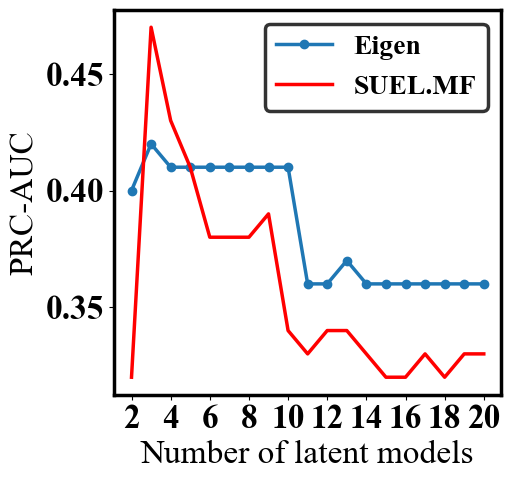

In [163]:
# Section 10
# The impact of number of latent models in the accuracy of different models
fig, ax = plt.subplots(figsize=(5,5))
font = {'family' : 'Times New Roman',
        'size'   : 20}

plt.rc('font', **font)
plt.rc('lines', linewidth=2.5)
plt.rcParams['axes.linewidth'] = 2.5#set the value globally
plt.rc('hatch', color='k', linewidth=2.5)
rr=[0.79,0.84,0.82,0.82,0.81,0.81,0.81,0.81,0.81,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80]
pr=[0.32,0.47,0.43,0.41,0.38,0.38,0.38,0.39,0.34,0.33,0.34,0.34,0.33,0.32,0.32,0.33,0.32,0.33,0.33]
rr_eig=[0.81,0.82,0.82,0.82,0.82,0.82,0.82,0.82,0.82,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81,0.81]
pr_eig=[0.40,0.42,0.41,0.41,0.41,0.41,0.41,0.41,0.41,0.36,0.36,0.37,0.36,0.36,0.36,0.36,0.36,0.36,0.36]
plt.plot(np.arange(2,21),pr_eig,marker="o")
plt.plot(np.arange(2,21),pr,"r")
plt.plot()
plt.ylabel("PRC-AUC")
plt.xticks(np.arange(2,21,2))
plt.xlabel("Number of latent models")
leg=plt.legend(["Eigen","SUEL.MF"], loc ="upper right")
leg.get_frame().set_edgecolor('k')
leg.get_frame().set_linewidth(2.5) 
plt.savefig('fig10-prc.tiff',format='tiff', dpi=600)

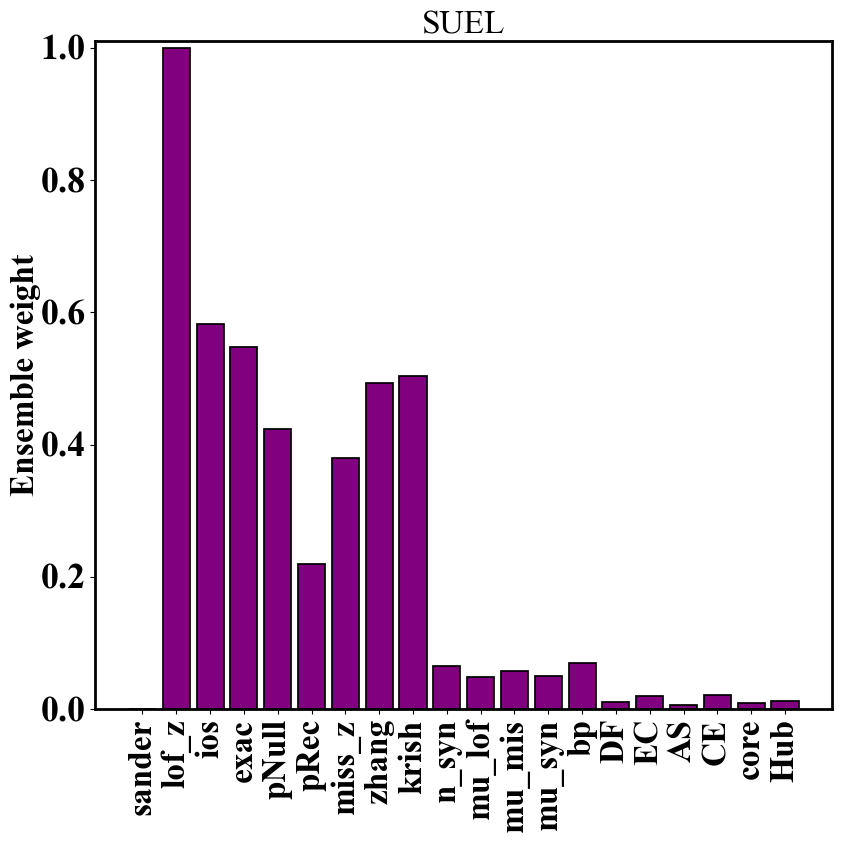

In [164]:
# Section 11
############################################ assigned weight to each scorein SUEL.MF
plt.figure(figsize=(9,9))
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)
plt.rc('lines', linewidth=1.5)
plt.rcParams['axes.linewidth'] = 2 #set the value globally
plt.rc('hatch', color='k', linewidth=1.5)
# Colorize the graph based on likeability:
# Map xs to numbers:
acc=(acc-min(acc))/(max(acc)-min(acc))
N = len(acc)
x_nums = np.arange(0, N)

# Plot a bar graph:
plt.bar(
    x_nums,
    acc,
    align="center",
    color="purple",
    linewidth=1.25,
    ec="k"
)
#plt.rcParams.update({'axes.titlesize': 'large'})
#plt.xlabel("Decile",labelpad=0,fontsize=18,weight='bold')
plt.ylabel("Ensemble weight",labelpad=0,fontsize=24, weight='bold')
#plt.title('MSSNG LOF\n ( {} / {} ; P= {} )'.format(numbers[0],overlap, 0.03), loc='center', fontsize=14)
plt.title("SUEL", loc='center', fontsize=24)
#plt.axis('equal')
plt.ylim((0,1.01))
plt.xticks(range(len(acc)),new_label, rotation=90,fontsize=24, weight='bold')
plt.tight_layout()
plt.savefig('estimated_accuracy.tiff',format='tiff', dpi=300)


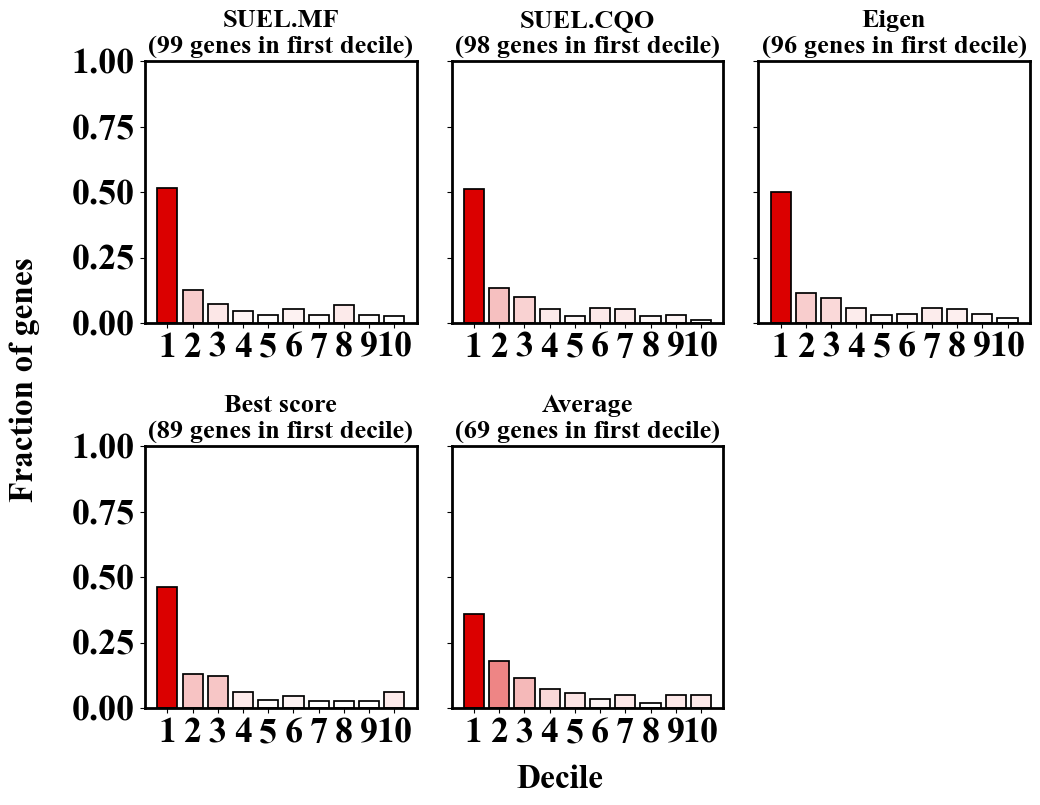

In [165]:
# Section 12
# The distribution of ASD genes across different decile of prediction models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

# Example ensemble scores for demonstration
ensemble_scores = [
    np.array(suel_mf),
    np.array(suel_cqo),
    np.array(eigen),
    np.array(best_score),
    np.array(average)
]

# Create subplots for each ensemble score
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharey=True)
font = {'family': 'Times New Roman', 'weight': 'bold', 'size': 20}
plt.rc('font', **font)

# List of labels for subplots
labels = ['SUEL.MF', 'SUEL.CQO', 'Eigen', 'Best score', 'Average']

# Iterate over each ensemble score and plot
for i, scores in enumerate(ensemble_scores):
    # Sort the scores and labels together
    inds = (-ensemble_scores[i]).argsort()
    gene= np.array(all_gene_scores["gene"]) # gene names
    sorted_gene = gene[inds]
    TP_gene=pd.read_csv("TP_new_aut.txt", dtype=str,header=None) # Names of ASD-related genes from literature
    tp_gene=np.array(TP_gene)
    def divide(lst, n):
        p = len(lst) // n
        if len(lst)-p > 0:
            return [lst[:p]] + divide(lst[p:], n-1)
        else:
            return [lst]
    lst=[]    
    lst=sorted_gene
    b= divide(lst,10)   

    counter=0
    numbers=[]
    for jj in range(0,len(b)):
      for ii in range(0, len(tp_gene)):
        if tp_gene[ii] in b[jj]:
            counter=counter+1
      numbers.append(counter)
      counter=0
    overlap=np.sum(np.array(numbers))  
    data=np.array(numbers)/np.sum(np.array(numbers))   


    # Plotting each ensemble score in the corresponding subplot
    row = i // 3  # Determine the row index (0 or 1)
    col = i % 3   # Determine the column index (0, 1, or 2)
    ax = axs[row, col]  # Select the correct subplot

    # Colorize the graph based on likeability:
    likeability_scores = -np.array(data)
    data_normalizer = mp.colors.Normalize()
    color_map = mp.colors.LinearSegmentedColormap(
        "my_map",
        {'blue':   ((0.0, 0.0, 0.0), 
                     (1.0, 1,   1)),  # red ), # blue
         'green': ((0.0, 0.0, 0.0),
                   (1.0, 1, 1)),
         'red':  ((0.0, 0.86, 0.86),
                  (1.0, 1, 1))  # blue
        }
    )

    # Map xs to numbers:
    N = len(data)
    x_nums = np.arange(1, N+1)

    # Plot a bar graph:
    ax.bar(
        x_nums,
        data,
        align="center",
        color=color_map(data_normalizer(likeability_scores)),
        linewidth=1.25,
        ec="k"
    )
   
    ax.set_title(f'{labels[i]}\n({numbers[0]} genes in first decile)', loc='center', fontsize=19, fontweight='bold')
    ax.set_ylim((0, 1))
    ax.set_xticks(x_nums)

# Remove any extra subplots if there are fewer than 6 ensembles
if len(ensemble_scores) < 6:
    for i in range(len(ensemble_scores), 6):
        fig.delaxes(axs.flatten()[i])

# Set common labels for the whole figure
fig.text(0.5, -0.01, 'Decile', ha='center', fontsize=24, fontweight='bold')
fig.text(-0.05, 0.5, 'Fraction of genes', va='center', rotation='vertical', fontsize=24, fontweight='bold')

plt.tight_layout()
plt.show()



fig.savefig('real data_ASD_dist_fig.tiff', format='tiff', dpi=600, bbox_inches='tight')